<a href="https://colab.research.google.com/github/bominwang/Bayesian-statistics-method/blob/bayesian-model-averaging-method/BMA_basedon_BNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
import os
from google.colab import drive
drive.mount('/content/drive')
# 这里一定要加绝对绝对路径os.path.abspath
path = '/content/drive/MyDrive/Colab Notebooks/bm_wang/Bayesian_statistics_method/bayesian_model_averaging'
sys.path.append(os.path.abspath(path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from functools import partial
import tqdm
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import sklearn
import sklearn.preprocessing

In [5]:
!pip install blitz-bayesian-pytorch
import blitz
import blitz.modules
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 KB 2.3 MB/s eta 0:00:00


**BNN代理模型构建**

生成标准化后的样本集，用于训练和测试

In [10]:
def generating_sample(func, var_inforamtion, all_count):

  num = int(all_count)
  # sampling for inputs
  ins = np.zeros(shape = [num, 1])
  ins_n = np.zeros(shape = [num, 1])
  var_num = len(var_inforamtion)
  for i in range(var_num):
    distribution_infromation = var_inforamtion[f'var_{i}']
    distribution_name = distribution_infromation[0]
    disrtibution_loc = distribution_infromation[1]
    disrtibution_scale = distribution_infromation[2]
    if distribution_name == 'uniform':
      distribution_mean = (disrtibution_scale + disrtibution_loc) / 2
      distribution_std = (pow((disrtibution_scale - disrtibution_loc), 2) / 12) ** 0.5
    else:
      distribution_mean = disrtibution_loc
      distribution_std = disrtibution_scale
    samples = getattr(np.random, distribution_name)(disrtibution_loc, disrtibution_scale, size = [num, 1])
    ins = np.append(ins, samples, axis = 1)
    ins_n = np.append(ins_n, (samples - distribution_mean) / distribution_std, axis = 1)
  
  ins = np.delete(ins, 0, axis = 1)
  ins_n = np.delete(ins_n, 0, axis = 1)
  # calculating for response
  labs = func(ins)
  
  labs_ss = sklearn.preprocessing.StandardScaler()
  labs = labs_ss.fit_transform(labs.reshape(-1,1))
  
  return ins_n, labs, labs_ss

In [11]:
def generating_dataset(ins, labs, train_count):
  num = ins.shape[0]
  # transformation from numpy.array to torch.tensor
  ins = torch.from_numpy(ins).float()
  labs = torch.from_numpy(labs).float()
  # split to train_set and test_set
  train_volume = int(train_count)
  data_index = list(range(num))
  train_index = random.sample(range(0, num), train_volume)
  test_index = np.setdiff1d(data_index, train_index)

  train_ins, train_labs = ins[train_index, :], labs[train_index, :]
  test_ins, test_labs = ins[test_index, :], labs[test_index, :]

  # packaging by DataLoader and TensorDataset
  train_set = TensorDataset(train_ins, train_labs)
  train_set = DataLoader(train_set, batch_size = train_volume)
  
  test_set = TensorDataset(test_ins, test_labs)
  test_set = DataLoader(test_set, batch_size = train_volume)

  return train_set, test_set

定义网络结构

In [12]:
@variational_estimator
class BayesianLinearRegression(nn.Module):

  def __init__(self, in_features, out_features):
    super().__init__()

    self.fc_1 = nn.Linear(in_features, in_features * 50)
    self.fc_2 = nn.Linear(in_features * 50, in_features * 100)
    self.fc_3 = nn.Linear(in_features * 100, in_features * 50)
    self.fc_4 = BayesianLinear(in_features * 50, in_features * 20)
    self.fc_5 = BayesianLinear(in_features * 20, out_features)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc_1(x))
    x = self.relu(self.fc_2(x))
    x = self.relu(self.fc_3(x))
    x = self.relu(self.fc_4(x))
    y = self.fc_5(x)
    
    return y

训练与测试

In [13]:
def evaluate(model, test_set, num_samples, std_multiplier, iterior):

  for index, (x_test, y_test) in enumerate(test_set):
    
    preds = [model(x_test) for i in range(num_samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    stds = preds.std(axis=0)
    
    ci_upper = means + (std_multiplier * stds)
    ci_lower = means - (std_multiplier * stds)
    
    ic_acc = (ci_lower <= y_test) * (ci_upper >= y_test)
    ic_acc = ic_acc.float().mean()

    plt.figure(iterior, figsize=(10, 8), dpi=80)
    count = list(range(means.shape[0]))
    plt.scatter(count, y_test, color = 'black')
    plt.plot(count, means.detach().numpy(), color = 'blue')
    
    plt.fill_between(count, ci_lower.squeeze().detach().numpy(), ci_upper.squeeze().detach().numpy(), alpha = 0.4, color = 'blue')
    
    plt.title(f'the error bar of the mdoel trained {iterior}th in test set ')
    plt.xlabel('Index of test data')
    plt.ylabel('Response')
    plt.show()
    print(f"the accuracy in test set is {ic_acc}")
  
  return means, stds

In [14]:
def training_precess(model, train_set, test_set, train_epoch):

  optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
  #criterion = torch.nn.SmoothL1Loss()
  criterion = torch.nn.MSELoss()
  loss_hist = []
  for epoch in trange(train_epoch):
    for index, (x_train, y_train) in enumerate(train_set):
      optimizer.zero_grad()
      loss = model.sample_elbo(inputs = x_train, labels = y_train, criterion = criterion, sample_nbr = 3, complexity_cost_weight = 1 / x_train.shape[0])
      loss_hist.append(loss.item())
      
      loss.backward()
      optimizer.step()
    
    if epoch % 500 == 0:
      evaluate(model, test_set, num_samples = 100, std_multiplier = 2, iterior = epoch)
  
  evaluate(model, test_set, num_samples = 100, std_multiplier = 2, iterior = epoch)
  plt.figure(epoch + 1, figsize=(10, 8), dpi=80)
  plt.plot(loss_hist)
  
  return model

In [15]:
def inverse_transforms(model, inverse_attribution, ins):
  # 对预测数据进行反转
  preds = model(ins)
  preds = inverse_attribution.inverse_transform(preds.detach().numpy())
  preds = torch.from_numpy(preds)
  return preds

In [16]:
def posterior_evaluation(func, model, var_information, num_samples, IT_SS):
  # sampling
  num = int(num_samples)
  ins = np.zeros(shape = [num, 1])
  ins_n = np.zeros(shape = [num, 1])
  var_num = len(var_information)
  for i in range(var_num):
    distribution_infromation = var_information[f'var_{i}']
    distribution_name = distribution_infromation[0]
    disrtibution_loc = distribution_infromation[1]
    disrtibution_scale = distribution_infromation[2]
    if distribution_name == 'uniform':
      distribution_mean = (disrtibution_scale + disrtibution_loc) / 2
      distribution_std = (pow((disrtibution_scale - disrtibution_loc), 2) / 12) ** 0.5
    else:
      distribution_mean = disrtibution_loc
      distribution_std = disrtibution_scale
    samples = getattr(np.random, distribution_name)(disrtibution_loc, disrtibution_scale, size = [num, 1])
    ins = np.append(ins, samples, axis = 1)
    ins_n = np.append(ins_n, (samples - distribution_mean) / distribution_std, axis = 1)
  
  ins = np.delete(ins, 0, axis = 1)
  ins_n = np.delete(ins_n, 0, axis = 1)

  labs = func(ins).reshape(-1,1)
  #labs = IT_SS.transform(labs)

  preds = [inverse_transforms(model, IT_SS, torch.from_numpy(ins_n).float()) for i in range(200)]
  preds = torch.stack(preds, dim = 0)
  
  plt.figure(9999999,figsize=(10, 8), dpi=80)
  sns.distplot(labs, hist=True, kde = True, fit_kws={'color':'c', 'label':'model1','linestyle':'-'})
  sns.distplot(preds.detach().numpy(), hist=True, kde = True, fit_kws={'color':'c', 'label':'model1','linestyle':'-'})
  plt.title('posterior distribution of bnn VS true distribution from the true func')

In [17]:
def pointwies_predictive(model, point, input_information, theta_information, theta_count, it):
  
  input_num = len(input_information)
  input = np.ones(shape = [1, input_num])
  
  for j in range(input_num):
    distribution_infromation = input_information[f'input_{j}']
    distribution_name = distribution_infromation[0]
    disrtibution_loc = distribution_infromation[1]
    disrtibution_scale = distribution_infromation[2]
    if distribution_name == 'uniform':
      distribution_mean = (disrtibution_scale + disrtibution_loc) / 2.0
      distribution_std = (pow((disrtibution_scale - disrtibution_loc), 2.0) / 12.0) ** 0.5
    else:
      distribution_mean = disrtibution_loc
      distribution_std = disrtibution_scale
    ins = (point[j] - distribution_mean) / distribution_std
    input[0, j] = ins
  
  theta_num = len(theta_information)
  theta = np.zeros(shape = [theta_count, 1])
  for i in range(theta_num):
    distribution_infromation = theta_information[f'theta_{i}']
    distribution_name = distribution_infromation[0]
    disrtibution_loc = distribution_infromation[1]
    disrtibution_scale = distribution_infromation[2]
    if distribution_name == 'uniform':
      distribution_mean = (disrtibution_scale + disrtibution_loc) / 2
      distribution_std = (pow((disrtibution_scale - disrtibution_loc), 2) / 12) ** 0.5
    else:
      distribution_mean = disrtibution_loc
      distribution_std = disrtibution_scale
    theta_sampling = getattr(np.random, distribution_name)(disrtibution_loc, disrtibution_scale, size = [theta_count, 1])
    theta = np.append(theta, ((theta_sampling - distribution_mean) / distribution_std).reshape(-1,1), axis = 1)
  theta = np.delete(theta, 0, axis = 1)
  
  input = np.repeat(input.reshape(1,-1), theta_count, axis = 0)
  input = np.concatenate([input, theta], axis = 1)

  input = torch.from_numpy(input).float()

  pred = [model(input) for k in range(200)]
  pred = torch.vstack(pred)
  pred = it.inverse_transform(pred.detach().numpy())

  mean = np.mean(pred, axis = 0)
  std = np.std(pred, axis = 0)

  mean_std = np.array([mean, std])
  return mean_std

In [18]:
def sequential_predictive(model, samples, input_information, theta_information, theta_count, it):
  sample_count = samples.shape[0]
  means_stds = np.ones(shape=[sample_count, 2])
  for i in range(sample_count):
    sample = samples[i, :]
    means_stds[i, :] = pointwies_predictive(model, sample, input_information, theta_information, theta_count, it).squeeze(-1)
  return means_stds

In [19]:
from bma_demo import Mathematical_examples_1
inf_model1 = {'var_0': ["uniform", 1, 360], 'var_1': ["uniform", 1.924 - 0.05 * 1.925, 1.924 + 0.05 * 1.924], 'var_2': ["uniform", 0.6 - 0.05 * 0.6, 0.6 + 0.05 * 0.6]}
inf_model2 = {'var_0': ["uniform", 1, 360], 'var_1': ["uniform", 0.995 - 0.05 * 0.995, 0.995 + 0.05 * 0.995], 'var_2': ["uniform", 24.65 - 0.05 * 24.65, 24.65 + 0.05 * 24.65]}
inf_model3 = {'var_0': ["uniform", 1, 360], 'var_1': ["uniform", 2.265 - 0.05 * 2.265, 2.265 + 0.05 * 2.265], 'var_2': ["uniform", 364.21 - 0.05 * 364.21, 364.21 + 0.05 * 364.21], 'var_3': ["uniform", 0.3 - 0.05 *  0.3, 0.3 + 0.05 *  0.3]}
inf_model4 = {'var_0': ["uniform", 1, 360], 'var_1': ["uniform", 1.541 - 0.05 * 1.541, 1.541 + 0.05 * 1.541], 'var_2': ["uniform", 0.097 - 0.05 * 0.097, 0.097 + 0.05 * 0.097], 'var_3': ["uniform", 0.6 - 0.05 *  0.6, 0.6 + 0.05 *  0.6]}
sampling_size = 200
train_size = 150
ins_1, labs_1, labs_ss1 = generating_sample(Mathematical_examples_1.func_1, inf_model1, sampling_size)
trainset_model1, testset_model1 = generating_dataset(ins_1, labs_1, train_size)

ins_2, labs_2, labs_ss2 = generating_sample(Mathematical_examples_1.func_2, inf_model2, sampling_size)
trainset_model2, testset_model2 = generating_dataset(ins_2, labs_2, train_size)

ins_3, labs_3, labs_ss3 = generating_sample(Mathematical_examples_1.func_3, inf_model3, sampling_size)
trainset_model3, testset_model3 = generating_dataset(ins_3, labs_3, train_size)

ins_4, labs_4, labs_ss4 = generating_sample(Mathematical_examples_1.func_4, inf_model4, sampling_size)
trainset_model4, testset_model4 = generating_dataset(ins_4, labs_4, train_size)
for i, (x, y) in enumerate(trainset_model1):
  print(f'ins shape of train data{x.shape}')
  print(f'labs shape of train data{y.shape}')

ins shape of train datatorch.Size([150, 3])
labs shape of train datatorch.Size([150, 1])


  0%|          | 0/3500 [00:00<?, ?it/s]

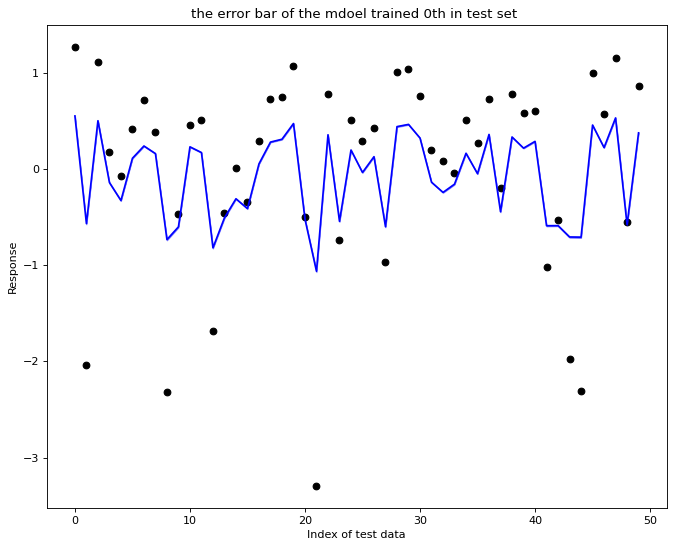

the accuracy in test set is 0.0


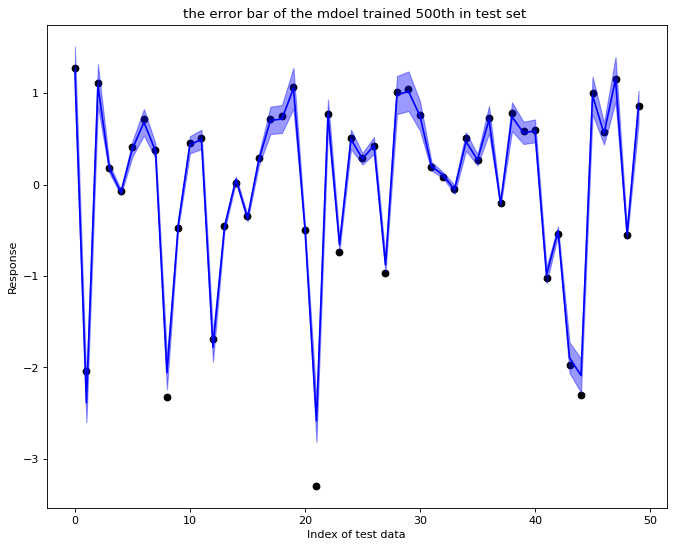

the accuracy in test set is 0.8399999737739563


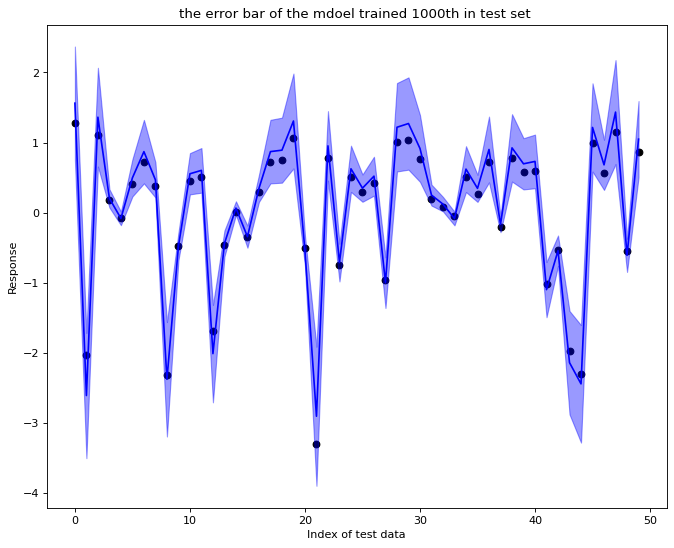

the accuracy in test set is 1.0


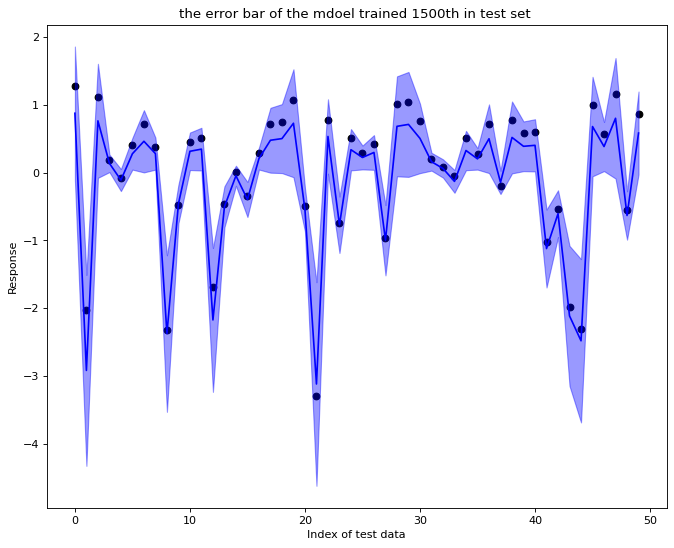

the accuracy in test set is 1.0


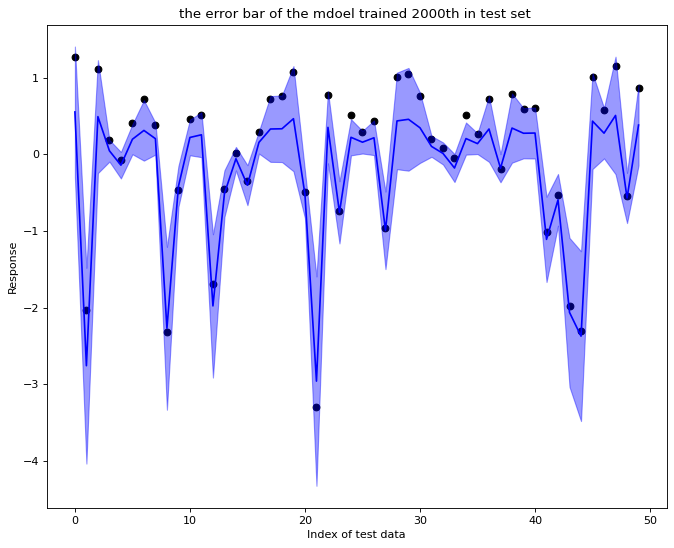

the accuracy in test set is 0.8999999761581421


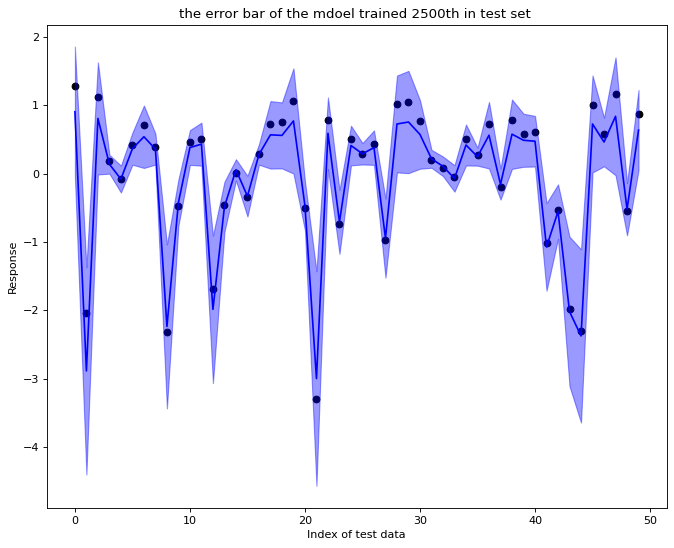

the accuracy in test set is 1.0


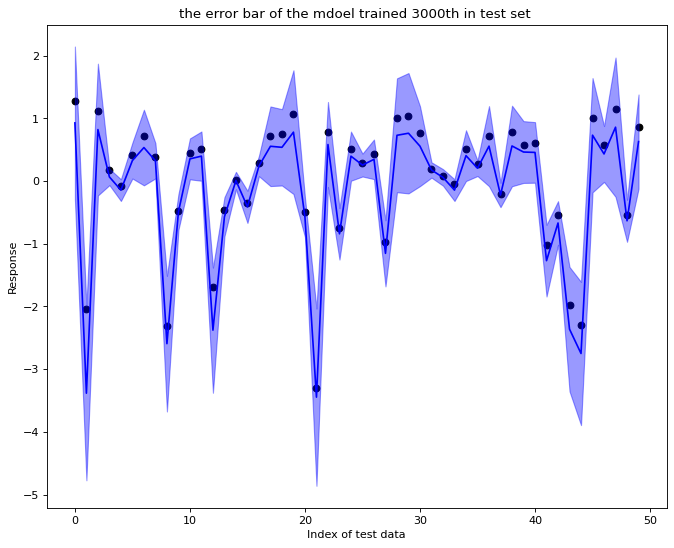

the accuracy in test set is 1.0


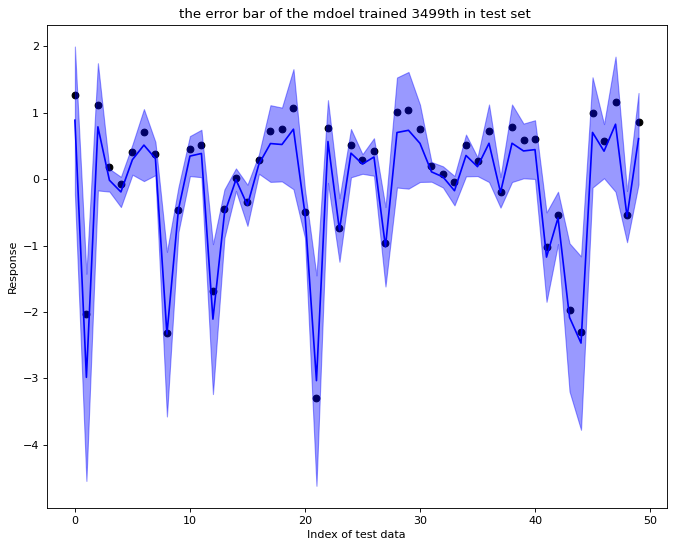

the accuracy in test set is 0.9800000190734863


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


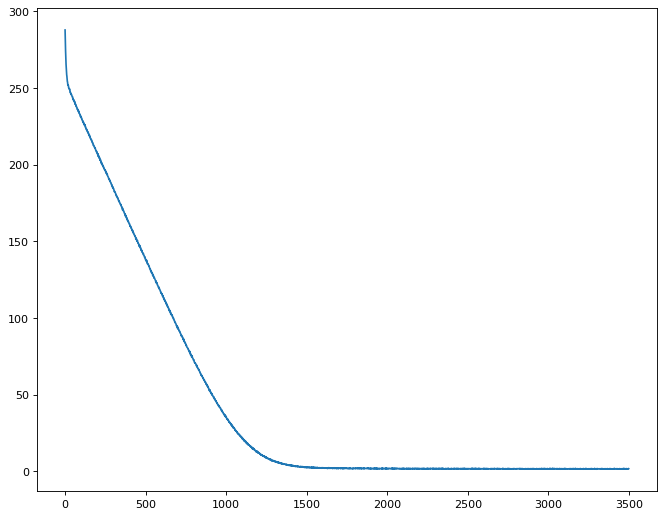

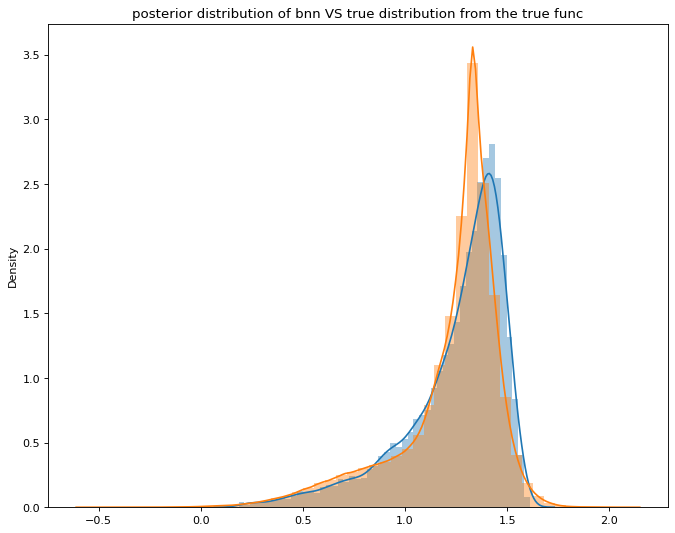

In [20]:
func1 = BayesianLinearRegression(3, 1)
training_precess(func1, trainset_model1, testset_model1, 3500)
posterior_evaluation(Mathematical_examples_1.func_1, func1, inf_model1, 10000, labs_ss1)

  0%|          | 0/3500 [00:00<?, ?it/s]

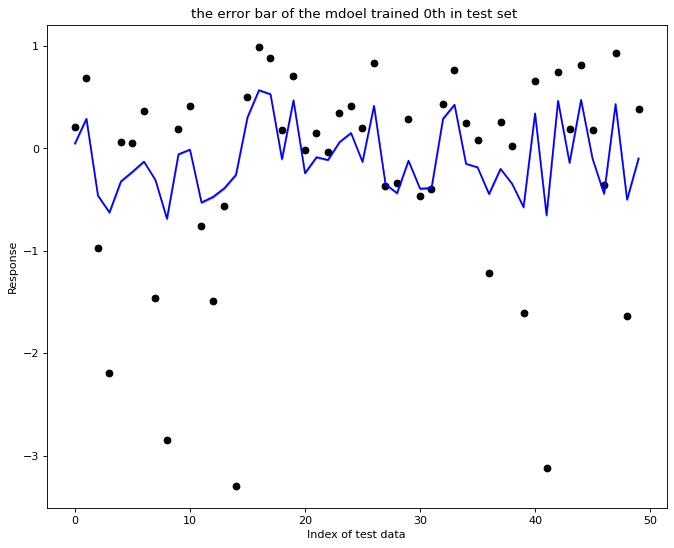

the accuracy in test set is 0.0


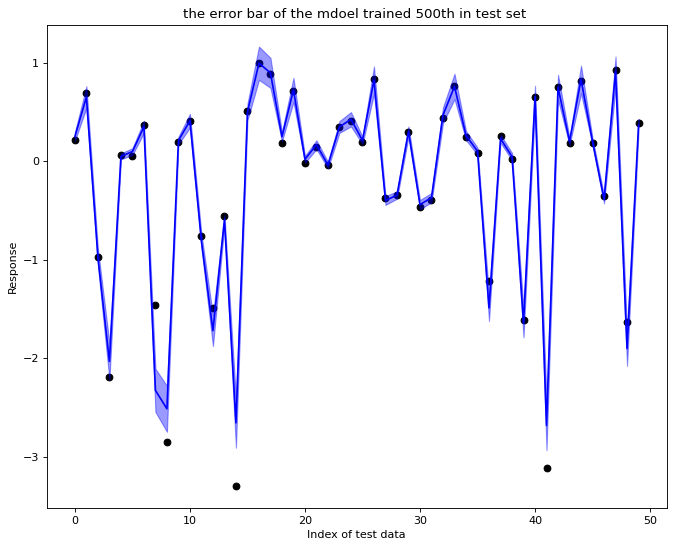

the accuracy in test set is 0.800000011920929


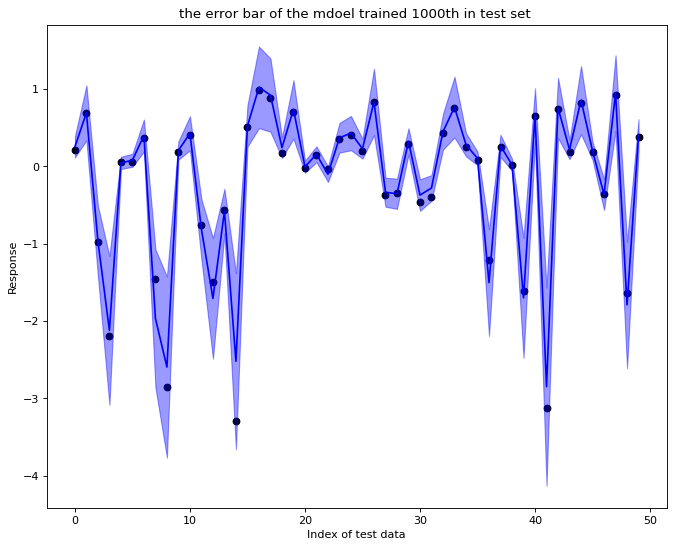

the accuracy in test set is 1.0


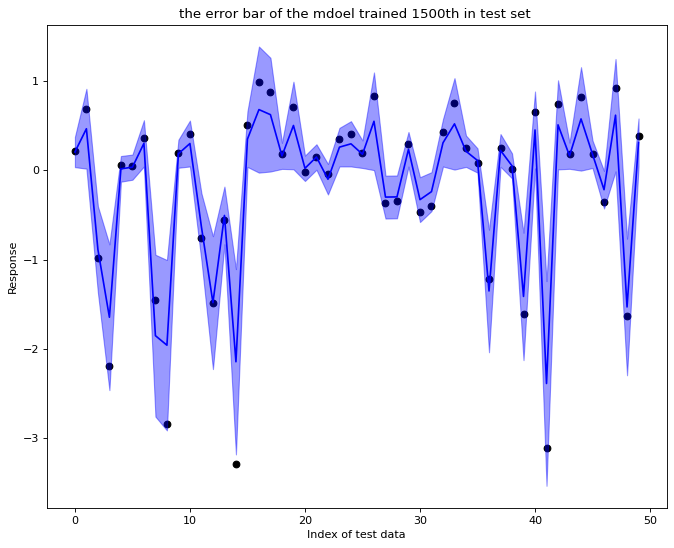

the accuracy in test set is 0.9800000190734863


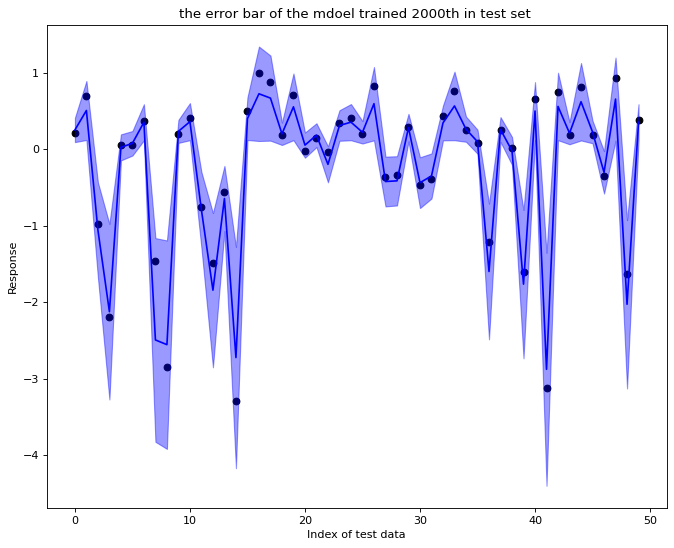

the accuracy in test set is 1.0


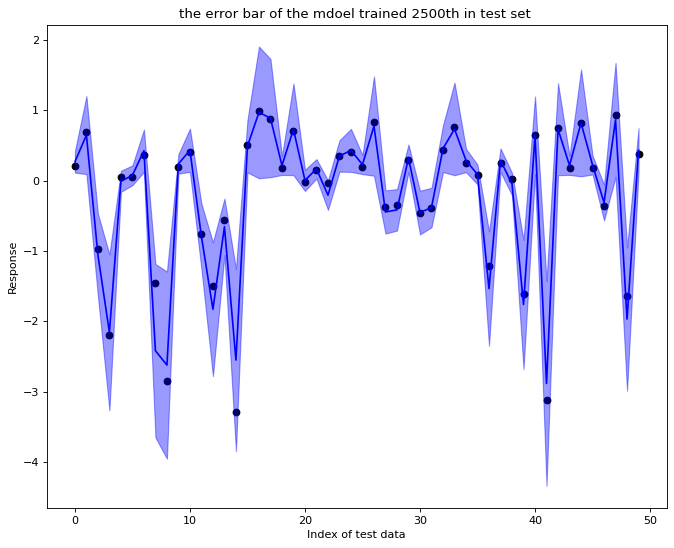

the accuracy in test set is 1.0


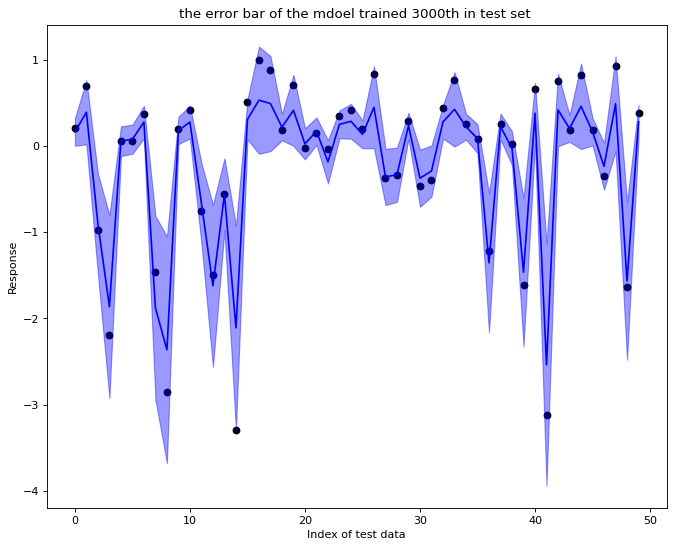

the accuracy in test set is 0.9800000190734863


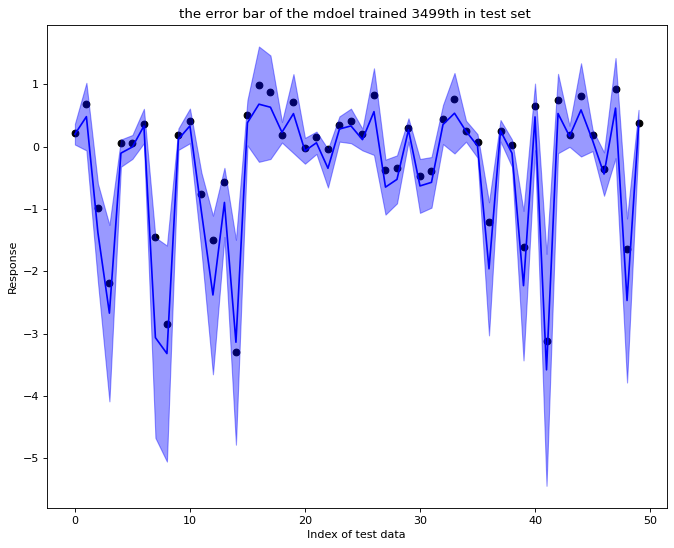

the accuracy in test set is 0.9800000190734863


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


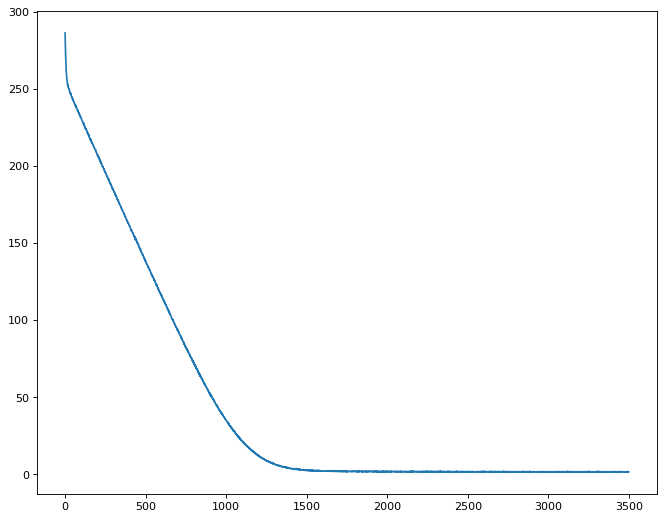

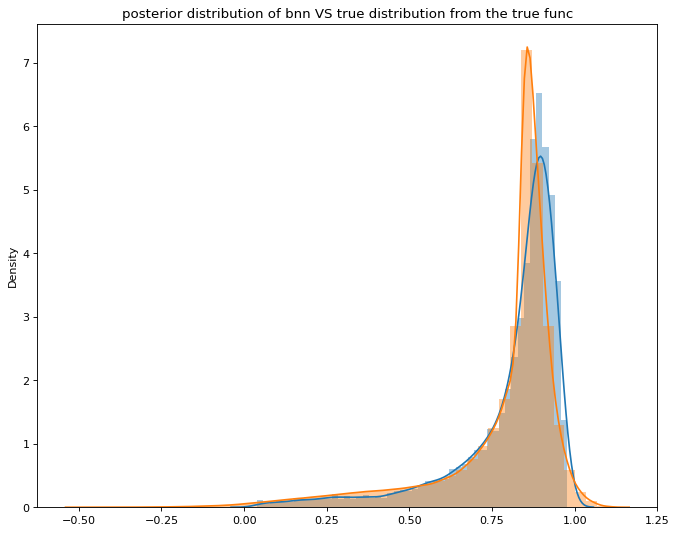

In [21]:
func2 = BayesianLinearRegression(3, 1)
training_precess(func2, trainset_model2, testset_model2, 3500)
posterior_evaluation(Mathematical_examples_1.func_2, func2, inf_model2, 10000, labs_ss2)

  0%|          | 0/3500 [00:00<?, ?it/s]

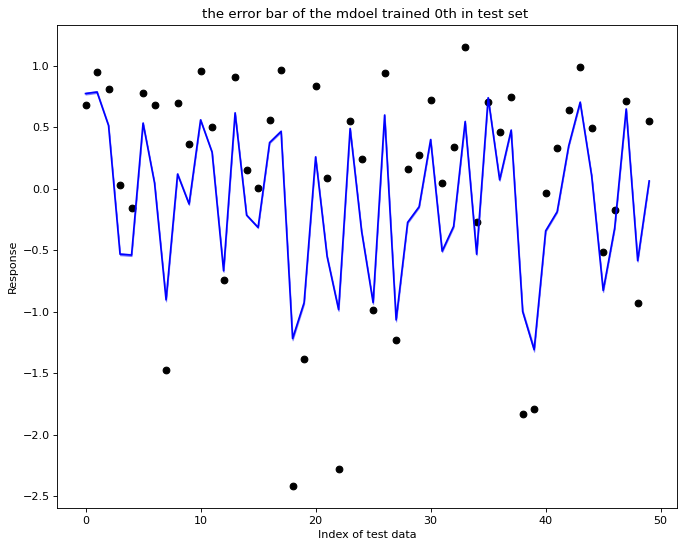

the accuracy in test set is 0.0


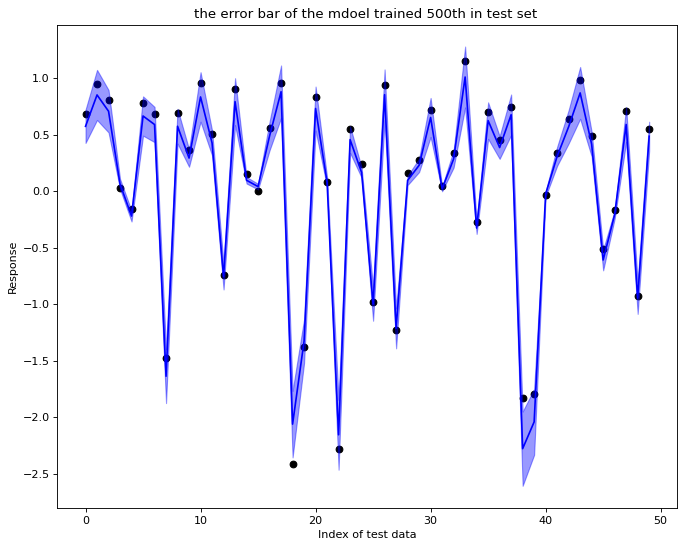

the accuracy in test set is 0.7799999713897705


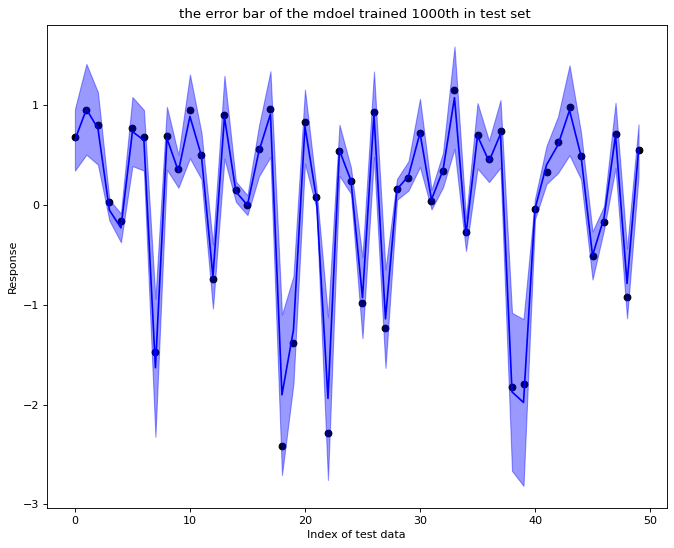

the accuracy in test set is 1.0


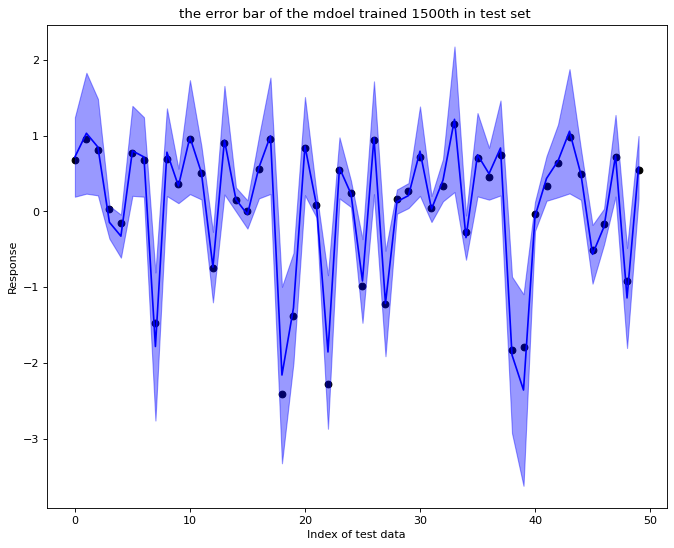

the accuracy in test set is 1.0


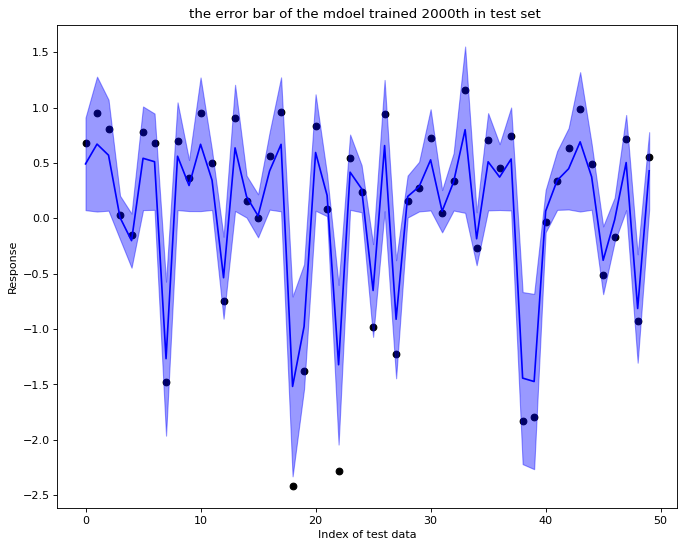

the accuracy in test set is 0.9599999785423279


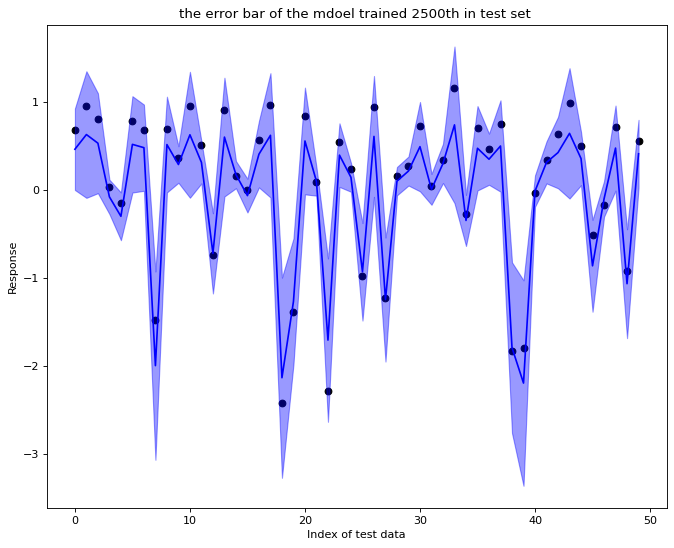

the accuracy in test set is 1.0


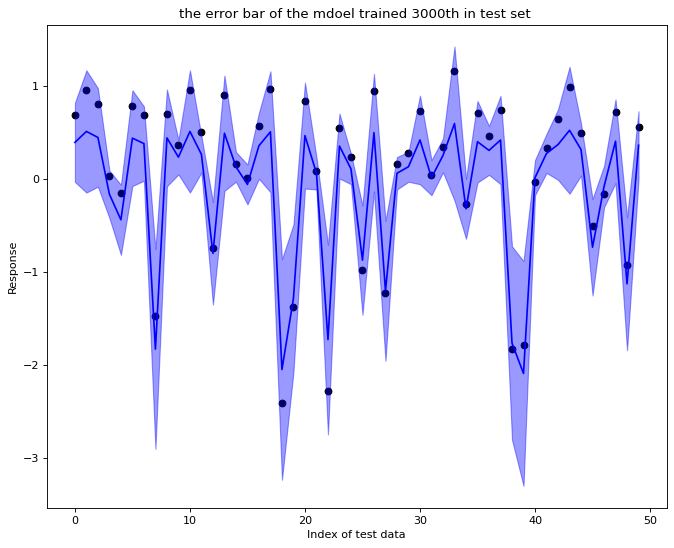

the accuracy in test set is 0.9800000190734863


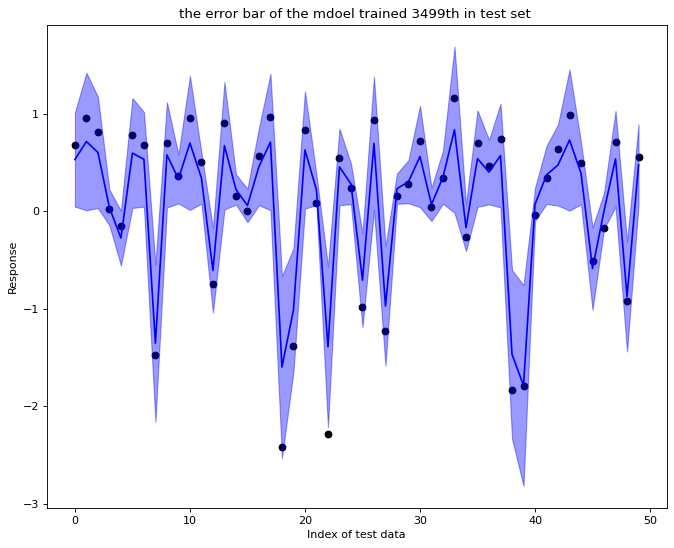

the accuracy in test set is 0.9800000190734863


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


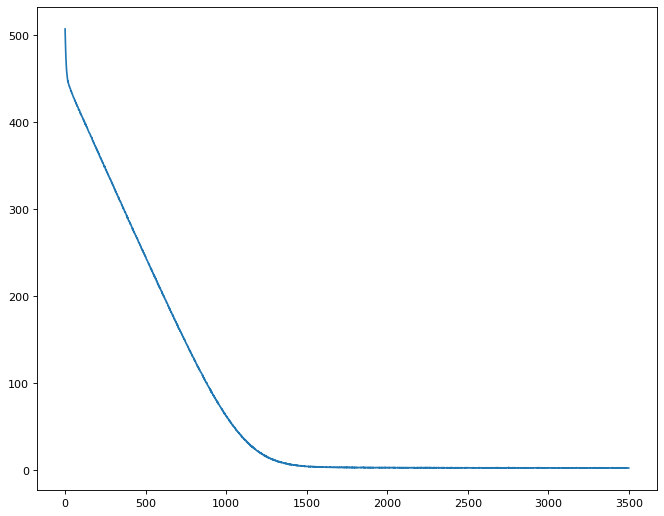

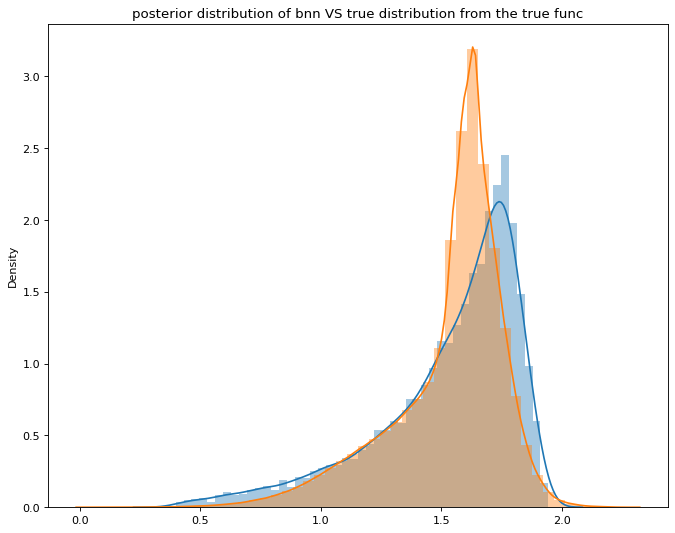

In [22]:
func3 = BayesianLinearRegression(4, 1)
training_precess(func3, trainset_model3, testset_model3, 3500)
posterior_evaluation(Mathematical_examples_1.func_3, func3, inf_model3, 10000, labs_ss3)

  0%|          | 0/3500 [00:00<?, ?it/s]

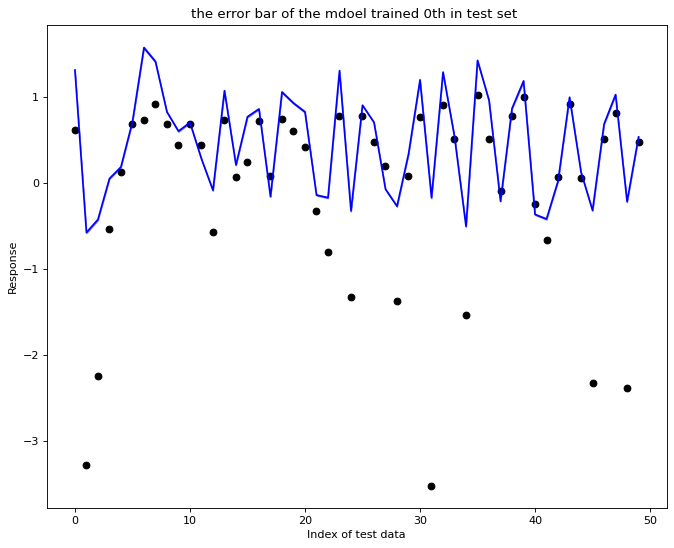

the accuracy in test set is 0.0


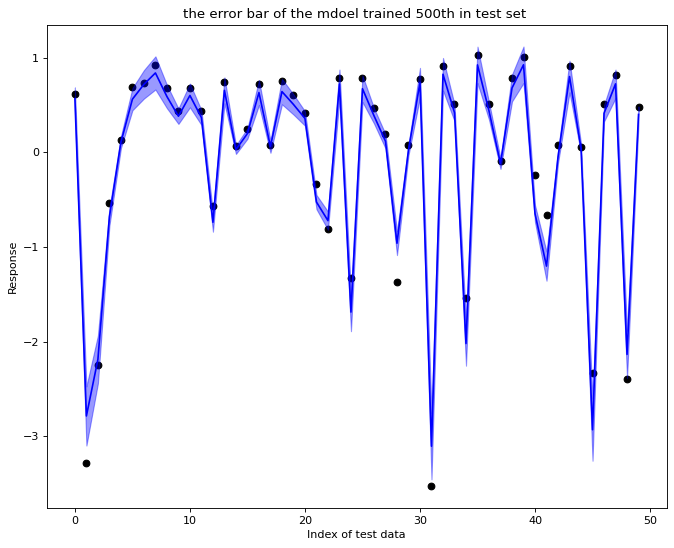

the accuracy in test set is 0.6399999856948853


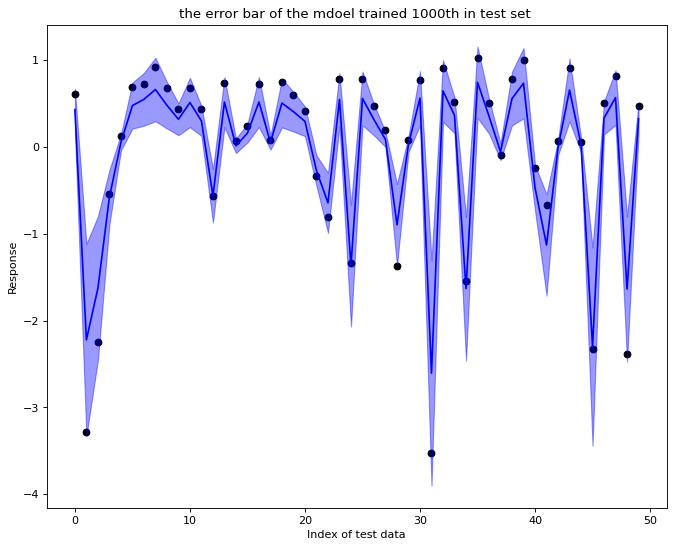

the accuracy in test set is 0.9599999785423279


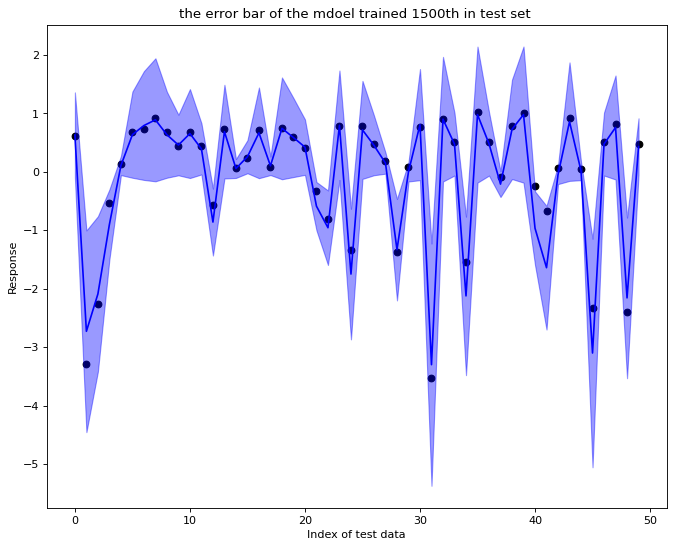

the accuracy in test set is 0.9800000190734863


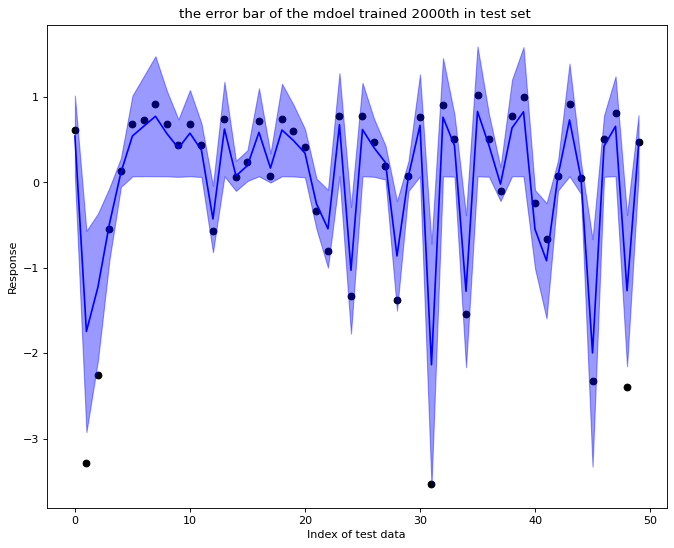

the accuracy in test set is 0.9399999976158142


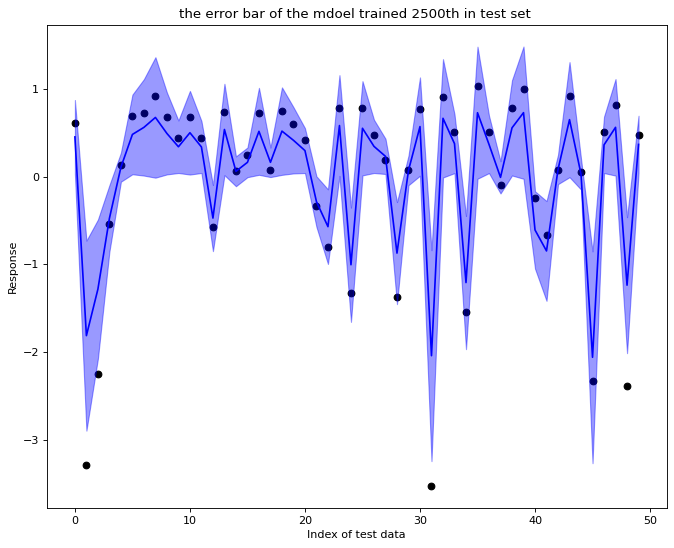

the accuracy in test set is 0.9200000166893005


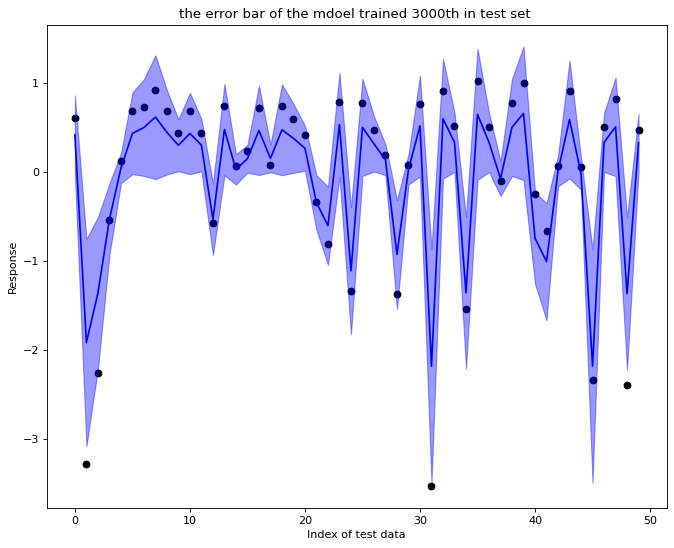

the accuracy in test set is 0.9200000166893005


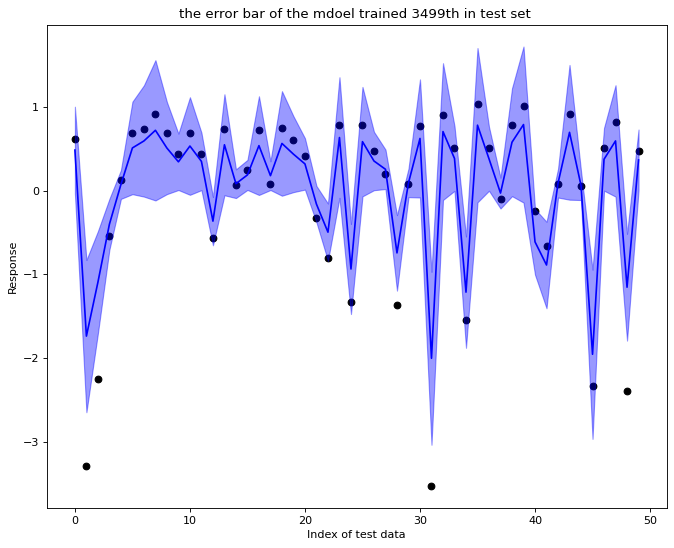

the accuracy in test set is 0.8999999761581421


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


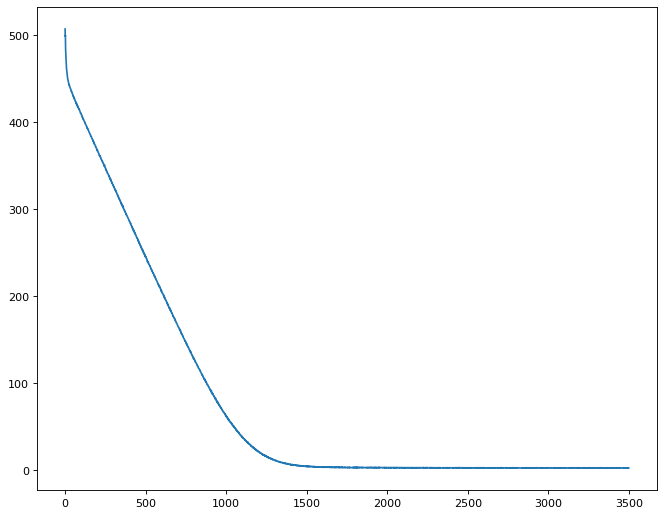

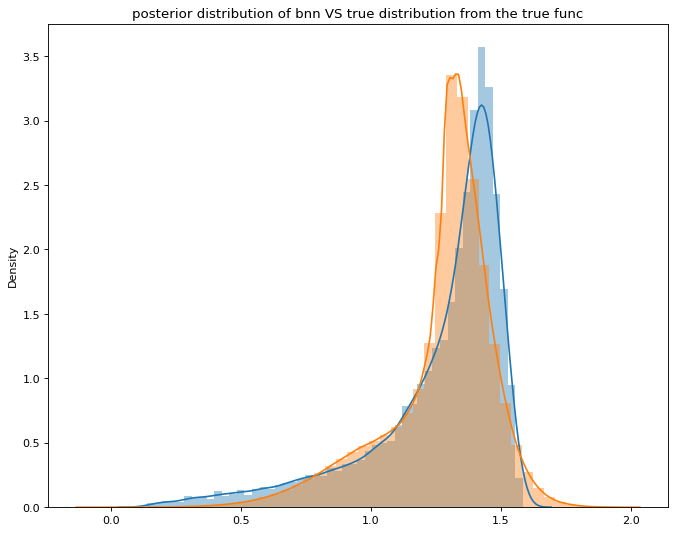

In [23]:
func4 = BayesianLinearRegression(4, 1)
training_precess(func4, trainset_model4, testset_model4, 3500)
posterior_evaluation(Mathematical_examples_1.func_4, func4, inf_model4, 20000, labs_ss4)

In [24]:
points = np.linspace(1, 360, 100).reshape(100, 1)
input_information = {'input_0' : ['uniform', 1, 360]}
inf_theta1 = {'theta_0': ["uniform", 1.924 - 0.05 * 1.925, 1.924 + 0.05 * 1.924], 'theta_1': ["uniform", 0.6 - 0.05 * 0.6, 0.6 + 0.05 * 0.6]}
inf_theta2 = {'theta_0': ["uniform", 0.995 - 0.05 * 0.995, 0.995 + 0.05 * 0.995], 'theta_1': ["uniform", 24.65 - 0.05 * 24.65, 24.65 + 0.05 * 24.65]}
inf_theta3 = {'theta_0': ["uniform", 2.265 - 0.05 * 2.265, 2.265 + 0.05 * 2.265], 'theta_1': ["uniform", 364.21 - 0.05 * 364.21, 364.21 + 0.05 * 364.21], 'theta_2': ["uniform", 0.3 - 0.05 *  0.3, 0.3 + 0.05 *  0.3]}
inf_theta4 = {'theta_0': ["uniform", 1.541 - 0.05 * 1.541, 1.541 + 0.05 * 1.541], 'theta_1': ["uniform", 0.097 - 0.05 * 0.097, 0.097 + 0.05 * 0.097], 'theta_2': ["uniform", 0.6 - 0.05 *  0.6, 0.6 + 0.05 *  0.6]}
theta_count = 300
means_stds_1 = sequential_predictive(func1, points, input_information, inf_theta1, theta_count, labs_ss1)
means_stds_2 = sequential_predictive(func2, points, input_information, inf_theta2, theta_count, labs_ss2)
means_stds_3 = sequential_predictive(func3, points, input_information, inf_theta3, theta_count, labs_ss3)
means_stds_4 = sequential_predictive(func4, points, input_information, inf_theta4, theta_count, labs_ss4)

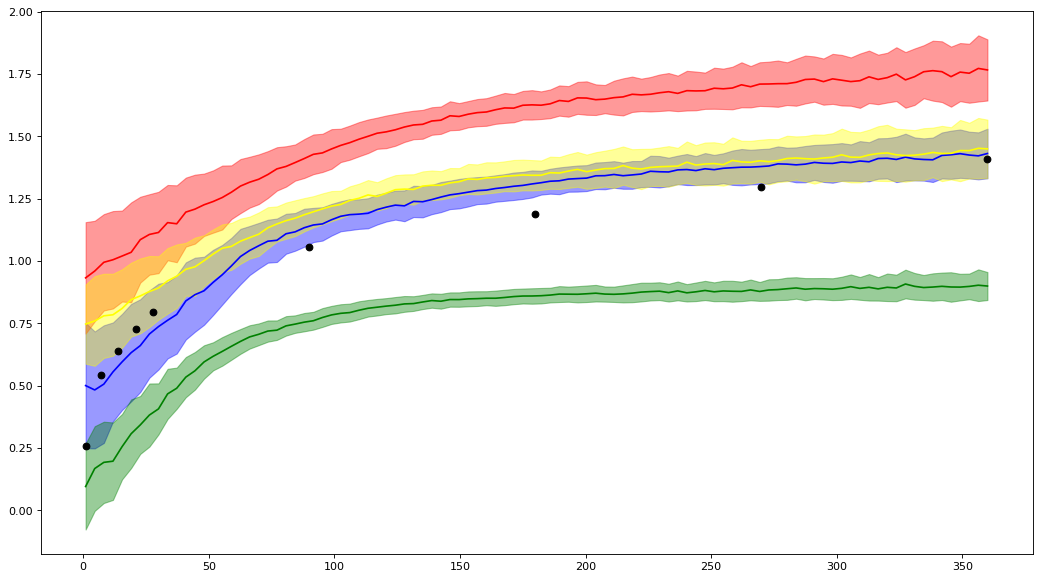

In [25]:
plt.figure(figsize = [16,9], dpi = 80)
plt.plot(points.reshape(-1,1), means_stds_1[:, 0], color = 'blue')
plt.fill_between(points.squeeze(-1), means_stds_1[:, 0] - means_stds_1[:, 1], means_stds_1[:, 0] + means_stds_1[:, 1], alpha = 0.4, color = 'blue')
plt.plot(points.reshape(-1,1), means_stds_2[:, 0], color = 'green')
plt.fill_between(points.squeeze(-1), means_stds_2[:, 0] - means_stds_2[:, 1], means_stds_2[:, 0] + means_stds_2[:, 1], alpha = 0.4, color = 'green')
plt.plot(points.reshape(-1,1), means_stds_3[:, 0], color = 'red')
plt.fill_between(points.squeeze(-1), means_stds_3[:, 0] - means_stds_3[:, 1], means_stds_3[:, 0] + means_stds_3[:, 1], alpha = 0.4, color = 'red')
plt.plot(points.reshape(-1,1), means_stds_4[:, 0], color = 'yellow')
plt.fill_between(points.squeeze(-1), means_stds_4[:, 0] - means_stds_4[:, 1], means_stds_4[:, 0] + means_stds_4[:, 1], alpha = 0.4, color = 'yellow')
in_exp = np.array([1,7,14,21,28,90,180,270,360]).reshape(-1, 1)
out_exp = np.array([0.259,0.544,0.639,0.727,0.796,1.054,1.189,1.297,1.410]).reshape(-1,1)
plt.scatter(in_exp, out_exp, color = 'black')


**BMA模型后验概率估计**

In [26]:
class likelihood_calculation(object):
  
  def __init__(self, input_exp, output_exp, input_information, theta_information, bnn_model, count_theta, count_weight, ITC):
    
    self.input_exp = input_exp    # 试验数据对应输入
    self.output_exp = output_exp   # 试验数据对应输出
    self.input_information = input_information # 随机输入分布信息
    self.theta_information = theta_information # 模型参数分布信息
    self.data_volume = input_exp.shape[0]   # 试验数据个数
    self.count_weight = count_weight   # 网络参数抽样量
    self.count_theta = count_theta    # 模型参数抽样量 
    self.model = bnn_model  # 贝叶斯神经网络
    self.ITC = ITC      # 网络输出反变换类
  
  def input_normalization(self):
    # 试验数据输入标准化
    input_num = len(self.input_information)
    sample_num = self.data_volume
    input_normalization = np.zeros(shape = [sample_num, input_num])
    for i in range(input_num):
      distribution_infromation = self.input_information[f'input_{i}']
      distribution_name = distribution_infromation[0]
      disrtibution_loc = distribution_infromation[1]
      disrtibution_scale = distribution_infromation[2]
      if distribution_name == 'uniform':
        distribution_mean = (disrtibution_scale + disrtibution_loc) / 2.0
        distribution_std = (pow((disrtibution_scale - disrtibution_loc), 2.0) / 12.0) ** 0.5
      else:
        distribution_mean = disrtibution_loc
        distribution_std = disrtibution_scale
      input_normalization[:, i] = (self.input_exp[:, i] - distribution_mean) / distribution_std
    return input_normalization # [样本量 * 随机输入数]
  
  def sampling_theta(self):
    # 依据参数分布信息对参数进行抽样
    theta_num = len(self.theta_information)
    theta = np.zeros(shape = [self.count_theta, theta_num])
    thetas = np.zeros(shape = [self.count_theta, self.data_volume, theta_num])
    for i in range(theta_num):
      distribution_infromation = self.theta_information[f'theta_{i}']
      distribution_name = distribution_infromation[0]
      disrtibution_loc = distribution_infromation[1]
      disrtibution_scale = distribution_infromation[2]
      if distribution_name == 'uniform':
        distribution_mean = (disrtibution_scale + disrtibution_loc) / 2.0
        distribution_std = (pow((disrtibution_scale - disrtibution_loc), 2.0) / 12.0) ** 0.5
      else:
        distribution_mean = disrtibution_loc
        distribution_std = disrtibution_scale
      theta_sampling = getattr(np.random, distribution_name)(disrtibution_loc, disrtibution_scale, size = [self.count_theta,1])
      theta[:, i] = ((theta_sampling - distribution_mean) / distribution_std).squeeze(-1)
    for j in range(self.count_theta):
      thetas[j, :, :] = theta[j, :].reshape(1, -1).repeat(self.data_volume, axis = 0)
    
    return thetas
  
  def inverse_transforms(self, input):
    # 网络预测反变换
    input = torch.from_numpy(input).float()
    preds = self.model(input)
    preds = self.ITC.inverse_transform(preds.reshape(-1,1).detach().numpy())
    preds = torch.from_numpy(preds)
    return preds
  
  def predictive(self, inputs):
    # 权重抽样
    preds = [self.inverse_transforms(inputs) for i in range(self.count_weight)]
    preds = torch.stack(preds).squeeze(-1)
    #[网络参数抽样数 * 试验样本数]：一行表示一组网络权重抽样的结果
    return preds.detach().numpy() 
  
  def sigma2_mle(self, out_model):
    
    out_exp = np.repeat(self.output_exp, self.count_weight, axis = 1)

    return np.mean(np.power(out_exp - out_model, 2), axis = 0) # [weight_count]
  
  def conditional_marginal_likelihood(self, sigma2):
    normalization_factor = 1.0 / (2.0 * np.pi * sigma2)
    return np.power(normalization_factor, 0.5 * self.data_volume) * np.exp(self.data_volume / -2.0)

  
  def marginal_likelihood(self, theta):
    ins = np.concatenate((self.input_normalization(), theta), axis = 1)
    out_model = self.predictive(ins)
    out_model = out_model.T
    sigma = self.sigma2_mle(out_model).reshape(-1,1)
    store_cl = self.conditional_marginal_likelihood(sigma) #[weight_count, 1]
    return np.mean(store_cl, axis = 0)
  
  def likelihood(self):
    thetas = self.sampling_theta()
    store_l = np.zeros(shape=[self.count_theta, 1])
    for i in trange(self.count_theta):
      store_l[i, 0] = self.marginal_likelihood(thetas[i, :, :])
    return np.mean(store_l, axis = 0)

In [27]:
def posterior_calculation(*args):
  # 根据整体似然计算结果求解后验概率并绘制饼状图
  num_model = len(args)
  lables = []
  posterior_pro = np.zeros(shape=[num_model])
  normalization_factor = sum(args)
  posterior_list = args / normalization_factor
  for i in range(num_model):
    model_name = f'model_{i+1}'
    lables.append(model_name)
    posterior_pro[i] = posterior_list[i]
  plt.figure(figsize=(10, 8), dpi=80)
  plt.pie(posterior_pro, labels = lables)
  plt.title("Posterior Probability of Model")
  plt.show()
  for j in range(num_model):
    print(f'posterior_pro of {lables[j]} is {posterior_pro[j]}')
  return posterior_pro

In [28]:
def Assessment_of_convergence(input_exp, output_exp, theta_information, model_set, epoch, initial_count_theta, initial_count_weight, flag_theta, flag_weight):
  # 验证整体似然及后验概率对于抽样数的收敛性
  num_model = len(theta_information)
  posterior_pro = np.ones(shape = [num_model, epoch])
  for i in trange(epoch):
    likelihood_save = np.zeros(shape=[num_model, 1])
    
    if flag_theta == 0:
      count_theta = initial_count_theta
    else:
      count_theta = initial_count_theta + (i * 100)
    if flag_weight == 0:
      count_weight = initial_count_weight
    else:
      count_weight = initial_count_weight + (i * 100)
    
    for j in range(num_model):
      likelihood_save[j, 0] = likelihood_calculation(input_exp, output_exp, theta_information[j], model_set[j], count_theta = count_theta, count_weight = count_weight).likelihood()
    posterior_pro[:, i] = (likelihood_save / np.sum(likelihood_save, axis = 0)).reshape(-1)
  
  plt.figure(figsize=(10, 8), dpi=80)
  for k in range(num_model):
    plt.plot(posterior_pro[k, :], label = f'model_{k}')
  plt.legend()
  plt.show()
  return posterior_pro

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

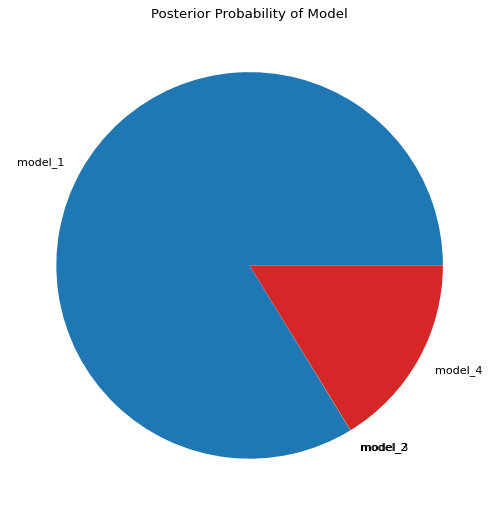

posterior_pro of model_1 is 0.8372750169664287
posterior_pro of model_2 is 7.219325428810317e-05
posterior_pro of model_3 is 0.0002021379571288672
posterior_pro of model_4 is 0.16245065182215426
[8.37275017e-01 7.21932543e-05 2.02137957e-04 1.62450652e-01]


In [29]:
inf_input = {'input_0' : ['uniform', 1, 360]}
inf_theta1 = {'theta_0': ["uniform", 1.924 - 0.05 * 1.925, 1.924 + 0.05 * 1.924], 'theta_1': ["uniform", 0.6 - 0.05 * 0.6, 0.6 + 0.05 * 0.6]}
inf_theta2 = {'theta_0': ["uniform", 0.995 - 0.05 * 0.995, 0.995 + 0.05 * 0.995], 'theta_1': ["uniform", 24.65 - 0.05 * 24.65, 24.65 + 0.05 * 24.65]}
inf_theta3 = {'theta_0': ["uniform", 2.265 - 0.05 * 2.265, 2.265 + 0.05 * 2.265], 'theta_1': ["uniform", 364.21 - 0.05 * 364.21, 364.21 + 0.05 * 364.21], 'theta_2': ["uniform", 0.3 - 0.05 *  0.3, 0.3 + 0.05 *  0.3]}
inf_theta4 = {'theta_0': ["uniform", 1.541 - 0.05 * 1.541, 1.541 + 0.05 * 1.541], 'theta_1': ["uniform", 0.097 - 0.05 * 0.097, 0.097 + 0.05 * 0.097], 'theta_2': ["uniform", 0.6 - 0.05 *  0.6, 0.6 + 0.05 *  0.6]}

in_exp = np.array([1,7,14,21,28,90,180,270,360]).reshape(-1, 1)
out_exp = np.array([0.259,0.544,0.639,0.727,0.796,1.054,1.189,1.297,1.410]).reshape(-1,1)

# input_exp, output_exp, input_information, theta_information, bnn_model, count_theta, count_weight, ITC
llh1 = likelihood_calculation(in_exp, out_exp, inf_input, inf_theta1, func1, count_theta = 200, count_weight = 1000, ITC = labs_ss1).likelihood()
llh2 = likelihood_calculation(in_exp, out_exp, inf_input, inf_theta2, func2, count_theta = 200, count_weight = 1000, ITC = labs_ss2).likelihood()
llh3 = likelihood_calculation(in_exp, out_exp, inf_input, inf_theta3, func3, count_theta = 200, count_weight = 1000, ITC = labs_ss3).likelihood()
llh4 = likelihood_calculation(in_exp, out_exp, inf_input, inf_theta4, func4, count_theta = 200, count_weight = 1000, ITC = labs_ss4).likelihood()
post = posterior_calculation(llh1, llh2, llh3, llh4)
print(post)

In [ ]:
# 收敛检验
#inf_theta1 = {'theta_0': ["uniform", 1.924 - 0.05 * 1.925, 1.924 + 0.05 * 1.924], 'theta_1': ["uniform", 0.6 - 0.05 * 0.6, 0.6 + 0.05 * 0.6]}
#inf_theta2 = {'theta_0': ["uniform", 0.995 - 0.05 * 0.995, 0.995 + 0.05 * 0.995], 'theta_1': ["uniform", 24.65 - 0.05 * 24.65, 24.65 + 0.05 * 24.65]}
#inf_theta3 = {'theta_0': ["uniform", 2.265 - 0.05 * 2.265, 2.265 + 0.05 * 2.265], 'theta_1': ["uniform", 364.21 - 0.05 * 364.21, 364.21 + 0.05 * 364.21], 'theta_2': ["uniform", 0.3 - 0.05 *  0.3, 0.3 + 0.05 *  0.3]}
#inf_theta4 = {'theta_0': ["uniform", 1.541 - 0.05 * 1.541, 1.541 + 0.05 * 1.541], 'theta_1': ["uniform", 0.097 - 0.05 * 0.097, 0.097 + 0.05 * 0.097], 'theta_2': ["uniform", 0.6 - 0.05 *  0.6, 0.6 + 0.05 *  0.6]}
#inf_theta = [inf_theta1, inf_theta2, inf_theta3, inf_theta4]
#model_set = [func1, func2, func3, func4]
#in_exp = np.array([1,7,14,21,28,90,180,270,360]).reshape(-1, 1)
#out_exp = np.array([0.259,0.544,0.639,0.727,0.796,1.054,1.189,1.297,1.410]).reshape(-1,1)
#pp = Assessment_of_convergence(in_exp, out_exp, inf_theta, model_set, 10, 100, 100, 1, 0)


**模型平均**


In [131]:
class pointwise_distribution(object):
  def __init__(self, input_exp, output_exp, model, point, input_information, theta_information, theta_count, weight_count, IT):
    self.input_exp = input_exp
    self.output_exp = output_exp
    self.model = model
    self.point = point
    self.input_information = input_information
    self.theta_information = theta_information
    self.theta_count = theta_count
    self.weight_count = weight_count
    self.IT = IT
    self.data_volume = output_exp.shape[0] 
  
  def normalization(self):
    # point数据标准化
    input_num = len(self.input_information)
    point = self.point.reshape(1, input_num)
    ins = np.concatenate([point, self.input_exp], axis = 0)
    normalization_input = np.zeros(shape = [int(self.data_volume + 1), input_num])    
    
    for i in range(input_num):
      distribution_infromation = self.input_information[f'input_{i}']
      distribution_name = distribution_infromation[0]
      disrtibution_loc = distribution_infromation[1]
      disrtibution_scale = distribution_infromation[2]
      if distribution_name == 'uniform':
        distribution_mean = (disrtibution_scale + disrtibution_loc) / 2
        distribution_std = (pow((disrtibution_scale - disrtibution_loc), 2) / 12) ** 0.5
      else:
        distribution_mean = disrtibution_loc
        distribution_std = disrtibution_scale
      normalization_input[:, i] = (ins[:, i] - distribution_mean) / distribution_std
    return normalization_input
  
  def sampling_theta(self):
    theta_num = len(self.theta_information)
    theta = np.zeros(shape = [self.theta_count, theta_num])
    for i in range(theta_num):
      distribution_infromation = self.theta_information[f'theta_{i}']
      distribution_name = distribution_infromation[0]
      disrtibution_loc = distribution_infromation[1]
      disrtibution_scale = distribution_infromation[2]
      if distribution_name == 'uniform':
        distribution_mean = (disrtibution_scale + disrtibution_loc) / 2.0
        distribution_std = (pow((disrtibution_scale - disrtibution_loc), 2.0) / 12.0) ** 0.5
      else:
        distribution_mean = disrtibution_loc
        distribution_std = disrtibution_scale
      theta_sampling = getattr(np.random, distribution_name)(disrtibution_loc, disrtibution_scale, size = [self.theta_count, 1])
      theta[:, i] = ((theta_sampling - distribution_mean) / distribution_std).squeeze(-1)
    return theta
  
  def joint_input(self, input, theta):
    theta = np.repeat(theta.reshape(1, -1), self.data_volume + 1, axis = 0)
    return np.concatenate([input, theta], axis = 1)
  
  def inverse_transforms(self, input):
    input = torch.from_numpy(input).float()
    pred = self.model(input)
    pred = self.IT.inverse_transform(pred.reshape(-1,1).detach().numpy())
    pred = torch.from_numpy(pred)
    return pred
  
  def predictive(self, input):
    preds = [self.inverse_transforms(input) for i in range(self.weight_count)]
    preds = torch.hstack(preds)
    return preds
  
  def sigma2_mle(self, out_model):
    out_model = out_model.detach().numpy()
    out_exp = np.repeat(self.output_exp, self.weight_count, axis = 1)
    return np.mean(np.power(out_exp - out_model, 2), axis = 0)
  
  def mean_calculation(self, input):
    input = input.detach().numpy()
    return np.mean(input, axis = 0)
  
  def var_calculation(self, input):
    sigma2 = self.sigma2_mle(input)
    return np.sum(sigma2) / pow(self.weight_count, 2) 
  
  def distribution_calculation(self):
    input = self.normalization()
    theta = self.sampling_theta()
    mean_theta = np.zeros(shape = [self.theta_count, 1])
    var_theta = np.zeros(shape = [self.theta_count, 1])
    for i in range(self.theta_count):
      ins = self.joint_input(input, theta[i, :])
      pred = self.predictive(ins)
      mean_theta[i, :] = self.mean_calculation(pred[0,:])
      var_theta[i, :] = self.var_calculation(pred[1 : self.data_volume + 2, :])
    return np.mean(mean_theta, axis = 0), np.sqrt(np.array([np.sum(var_theta) / pow(self.theta_count, 2)]))

In [132]:
def sequential_distribution(input_exp, output_exp, model, points, input_information, theta_information, theta_count, weight_count, IT):
  count = points.shape[0]
  mean_set = np.zeros(shape = [count, 1])
  std_set = np.zeros(shape = [count, 1])
  for i in trange(count):
    point = points[i, :]
    mean_set[i, :], std_set[i, :] = pointwise_distribution(input_exp, output_exp, model, point, input_information, theta_information, theta_count, weight_count, IT).distribution_calculation()
  return mean_set, std_set

In [210]:
class model_averaging_distribution(object):
  def __init__(self, mean_set, std_set, posterior_set):
    self.mean_set = mean_set
    self.std_set = std_set
    self.posterior_set = posterior_set
    self.sample_volume = mean_set[0].shape[0]
    self.model_volume = len(mean_set)
  def mu_calculation(self):
    mu_store = np.zeros(shape = [self.sample_volume, self.model_volume])
    for i in range(self.model_volume):
      weight_mu = self.mean_set[i] * self.posterior_set[i]
      mu_store[:, i] = weight_mu.squeeze(-1)
    return np.sum(mu_store, axis = 1)
  def var_calculation(self):
    inner_var = np.zeros(shape = [self.sample_volume, self.model_volume])
    for i in range(self.model_volume):
      weight_var = self.std_set[i] * self.posterior_set[i]
      inner_var[:, i] = weight_var.squeeze(-1)
    inner_var = np.sum(inner_var, axis = 1)

    out_var = np.zeros(shape = [self.sample_volume, self.model_volume])
    for j in range(self.model_volume):
      error = np.power(self.mean_set[j].reshape(-1,1) - self.mu_calculation().reshape(-1,1), 2)
      out_var[:, j] = (error * self.posterior_set[j]).squeeze(-1)
    out_var = np.sum(out_var, axis = 1)
    std = np.sqrt(inner_var + out_var)
    return std 

In [213]:
points = np.linspace(1, 360, 100).reshape(100, 1)
inf_input = {'input_0' : ['uniform', 1, 360]}
inf_theta1 = {'theta_0': ["uniform", 1.924 - 0.05 * 1.925, 1.924 + 0.05 * 1.924], 'theta_1': ["uniform", 0.6 - 0.05 * 0.6, 0.6 + 0.05 * 0.6]}
inf_theta2 = {'theta_0': ["uniform", 0.995 - 0.05 * 0.995, 0.995 + 0.05 * 0.995], 'theta_1': ["uniform", 24.65 - 0.05 * 24.65, 24.65 + 0.05 * 24.65]}
inf_theta3 = {'theta_0': ["uniform", 2.265 - 0.05 * 2.265, 2.265 + 0.05 * 2.265], 'theta_1': ["uniform", 364.21 - 0.05 * 364.21, 364.21 + 0.05 * 364.21], 'theta_2': ["uniform", 0.3 - 0.05 *  0.3, 0.3 + 0.05 *  0.3]}
inf_theta4 = {'theta_0': ["uniform", 1.541 - 0.05 * 1.541, 1.541 + 0.05 * 1.541], 'theta_1': ["uniform", 0.097 - 0.05 * 0.097, 0.097 + 0.05 * 0.097], 'theta_2': ["uniform", 0.6 - 0.05 *  0.6, 0.6 + 0.05 *  0.6]}
in_exp = np.array([1,7,14,21,28,90,180,270,360]).reshape(-1, 1)
out_exp = np.array([0.259,0.544,0.639,0.727,0.796,1.054,1.189,1.297,1.410]).reshape(-1,1)
mean_set1, std_set1 = sequential_distribution(in_exp, out_exp, func1, points, inf_input, inf_theta1, 20, 20, labs_ss1)
mean_set2, std_set2 = sequential_distribution(in_exp, out_exp, func2, points, inf_input, inf_theta2, 20, 20, labs_ss2)
mean_set3, std_set3 = sequential_distribution(in_exp, out_exp, func3, points, inf_input, inf_theta3, 20, 20, labs_ss3)
mean_set4, std_set4 = sequential_distribution(in_exp, out_exp, func4, points, inf_input, inf_theta4, 20, 20, labs_ss4)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [214]:
means_set = [mean_set1, mean_set2, mean_set3, mean_set4]
std_set = [std_set1, std_set2, std_set3, std_set4]
mean = model_averaging_distribution(means_set, std_set, post).mu_calculation()
std = model_averaging_distribution(means_set, std_set, post).var_calculation()

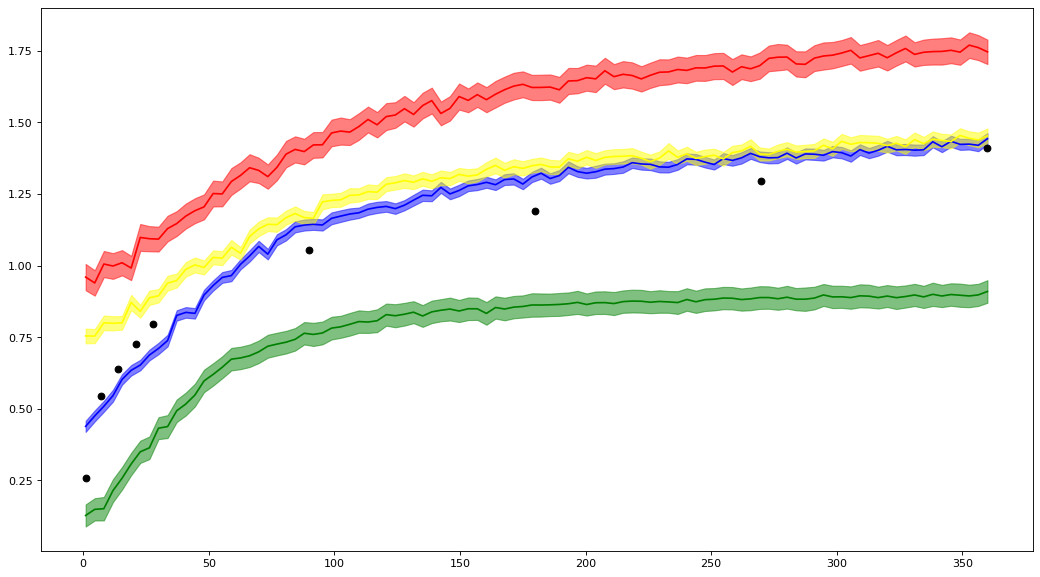

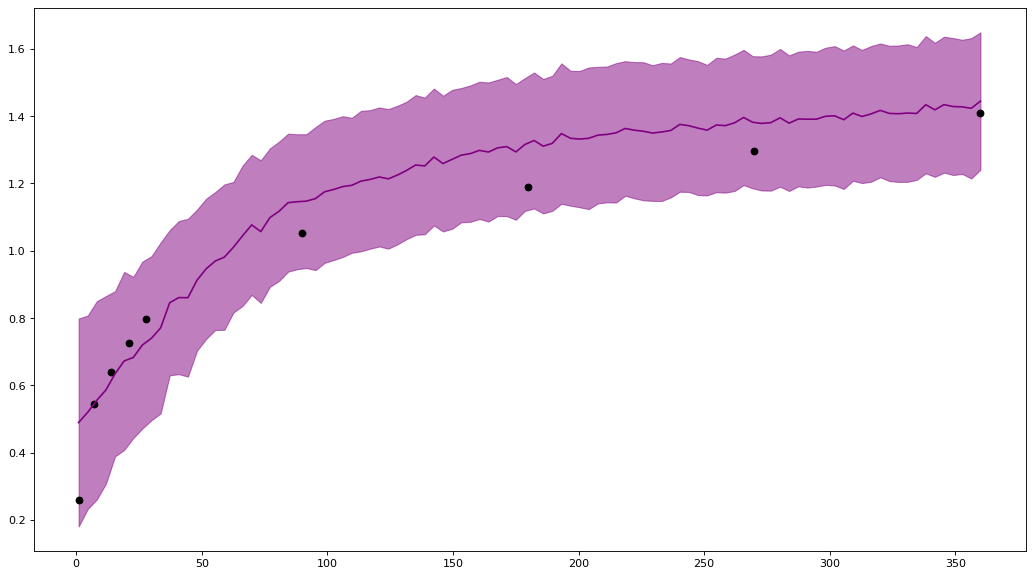

In [215]:
plt.figure(1, figsize = [16,9], dpi = 80)
plt.plot(points, mean_set1, color = 'blue')
plt.fill_between(points.squeeze(-1), (mean_set1 - 2 * std_set1).squeeze(-1), (mean_set1 + 2 * std_set1).squeeze(-1), alpha = 0.5, color = 'blue')
plt.plot(points, mean_set2, color = 'green')
plt.fill_between(points.squeeze(-1), (mean_set2 - 2 * std_set2).squeeze(-1), (mean_set2 + 2 * std_set2).squeeze(-1), alpha = 0.5, color = 'green')
plt.plot(points, mean_set3, color = 'red')
plt.fill_between(points.squeeze(-1), (mean_set3 - 2 * std_set3).squeeze(-1), (mean_set3 + 2 * std_set3).squeeze(-1), alpha = 0.5, color = 'red')
plt.plot(points, mean_set4, color = 'yellow')
plt.fill_between(points.squeeze(-1), (mean_set4 - 2 * std_set4).squeeze(-1), (mean_set4 + 2 * std_set4).squeeze(-1), alpha = 0.5, color = 'yellow')
plt.scatter(in_exp, out_exp, color = 'black')
plt.figure(2, figsize= [16, 9], dpi = 80)
plt.plot(points, mean, color = 'purple')
ci_low = mean - 2 * std
ci_up = mean + 2 * std
plt.fill_between(points.squeeze(-1), ci_low, ci_up, alpha = 0.5, color = 'purple')
plt.scatter(in_exp, out_exp, color = 'black')
